In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [3]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/'
training_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/train/'
validation_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/val/'
test_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/data/test/'
model_path = '/content/drive/My Drive/Colab Notebooks/cotton_disease/resnet_50_model.h5'

IMAGE_SIZE = [224, 224,3]
EPOCHS = 30
TARGET_SIZE = (224,224)
BATCH_SIZE = 16

In [4]:
# useful for getting number of output classes
folders = glob(training_path+'*')
print(len(folders))

4


In [5]:
# importing the resnet and using the imagenet weights
# Here we will be using imagenet weights

resnet_50 = ResNet50(include_top=False,weights='imagenet',input_shape=IMAGE_SIZE)

94773248/94765736 [==============================] - 0s 0us/step


In [6]:
# don't train existing weights
for layer in resnet_50.layers:
  layer.trainable = False

In [7]:
# our layers - you can add more if you want
x_network = Flatten()(resnet_50.output)
# adding the prediction layer
prediction_layer = Dense(len(folders),activation='softmax')(x_network)

In [8]:
# create a model object
model = Model(inputs = resnet_50.input , outputs = prediction_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:
# compiling the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [10]:
# creating callbacks to save best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= model_path,
                                                               save_weights_only='False',
                                                               monitor='val_accuracy',
                                                               save_best_only=True)


In [11]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = None):
    k = list(logs.keys())
    # print(k)
    if(logs.get('val_accuracy') > 0.99):
      print('Required accuracy reached , so stopping training.....!!')
      self.model.stop_training = True
  

In [12]:
# creating datagenerators

# train datagenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# test datagenerator
test_datagen = ImageDataGenerator(rescale= 1./255)

In [13]:
training_data = train_datagen.flow_from_directory(training_path,
                                                  target_size = TARGET_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical')

validation_dataset = test_datagen.flow_from_directory(validation_path,
                                                   target_size = TARGET_SIZE,
                                                   batch_size = BATCH_SIZE,
                                                   class_mode = 'categorical')

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [14]:
# fit the model

r = model.fit_generator(training_data,
                        validation_data = validation_dataset,
                        epochs = EPOCHS,
                        steps_per_epoch = len(training_data),
                        validation_steps = len(validation_dataset),
                        callbacks=[model_checkpoint_callback , MyCallback()])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
122/122 [==============================] - 1129s 9s/step - loss: 2.0563 - accuracy: 0.4485 - val_loss: 1.7328 - val_accuracy: 0.3025
Epoch 2/30
122/122 [==============================] - 44s 361ms/step - loss: 1.1781 - accuracy: 0.5853 - val_loss: 0.9307 - val_accuracy: 0.6759
Epoch 3/30
122/122 [==============================] - 39s 323ms/step - loss: 1.0174 - accuracy: 0.6263 - val_loss: 1.5066 - val_accuracy: 0.5154
Epoch 4/30
122/122 [==============================] - 39s 322ms/step - loss: 0.9614 - accuracy: 0.6591 - val_loss: 0.9290 - val_accuracy: 0.5988
Epoch 5/30
122/122 [==============================] - 43s 353ms/step - loss: 1.0379 - accuracy: 0.6433 - val_loss: 0.7130 - val_accuracy: 0.7346
Epoch 6/30
122/122 [==============================] - 40s 324ms/step - loss: 1.0494 - accuracy: 0.6443 - val_loss: 1.7337 - val_accuracy: 0.5895
Epoch 7/30
122/122 [==============================] - 3

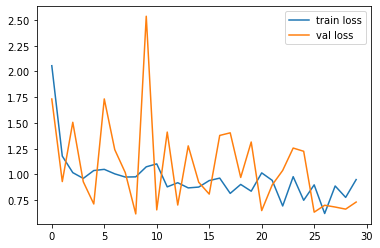

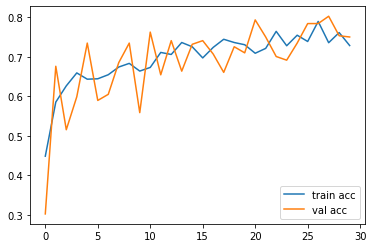

<Figure size 432x288 with 0 Axes>

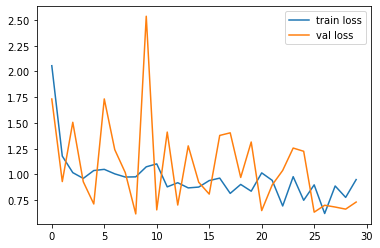

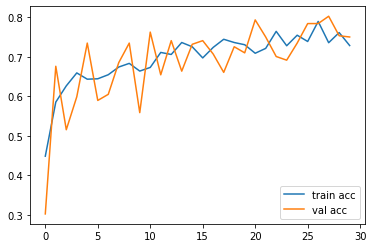

<Figure size 432x288 with 0 Axes>

In [16]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')